In [5]:
import yfinance as yf
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import warnings
warnings.filterwarnings('ignore')

# ✅ 한글 폰트 설정
def set_korean_font():
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = fm.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    # 한글 폰트 적용
    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

# ✅ 주가 데이터 불러오기
def load_stock_data(ticker, months=18):
    today = date.today()
    startD = today - relativedelta(months=months)
    endD = today
    return yf.download(ticker, startD, endD)

# ✅ 수익률 평균과 표준편차 계산
def calc_return_stats(stock_data):
    returns = stock_data['Close'].pct_change().dropna()
    mu = returns.mean()
    sigma = returns.std()
    return mu, sigma


## 시나리오별 모수

- 람다( $\lambda $) : 연간 기대 점프 횟수
- $\sigma$ : 연속적 변동성 (확산계수??)
- W(t) : 브라운 운동???
- N(t) : 강도가 $\lambda$인 포아송 프로세스
- 점프 크기 : 평균 0, 표준편차 $\sigma$ >>>> 우리는 bad news를 가정하기 때문에 평균이 음수가 된다.


1. 보수적인 시나리오 ( 일반적인 Bad News )

- 람다( $\lambda $) : 0.12
- $\sigma$ : 0.25
- 점프 크기 : 평균 -1.0, 표준편차 0.45


2. 중간 시나리오 ( 심각한 Bad News )

- 람다( $\lambda $) : 0.15
- $\sigma$ : 0.35
- 점프 크기 : 평균 -1.3, 표준편차 0.55

3. 극한 시나리오 ( 기업스캔들 / 위기 )

- 람다( $\lambda $) : 0.20
- $\sigma$ : 0.45
- 점프 크기 : 평균 -1.8, 표준편차 0.7

4. S&P 500에서의 실증 연구

- 람다( $\lambda $) : 0.089
- $\sigma$ : 0.1765
- 점프 크기 : 평균 -0.8898, 표준편차 0.4505

### 보수적인 시나리오

In [9]:

# ✅ 몬테카를로 시뮬레이션
# 일별 변동성을 가정하였으므로 T는 일수가 될 것임. >>> 수정필요!
def run_simulations(last_price, mu, daily_vol, num_simulations=30, T=252, lambda_event=0.23, jump_mu=-0.01, jump_vol=0.045):
    df = pd.DataFrame()
    last_price_list = []
    jump_indices_list = []  # 점프 발생 인덱스 리스트
    count_jump = []
    lambda_event = lambda_event / 252

    for _ in range(num_simulations):
        count = 0
        price_list = []
        price = last_price * (1 + np.random.normal(mu, daily_vol))
        price_list.append(price)
        jump_indices = []  # 각 시뮬레이션별 점프 인덱스

        for t in range(T):
            event = np.random.poisson(lambda_event)
            if event == 1:
                jump_return = np.random.normal(jump_mu, jump_vol) # jump의 분포에 대한 설명이 부족함
                price = price * (1 + jump_return)
                jump_indices.append(count)  # 점프 발생 위치 기록
            else:
                price = price_list[count] * (1 + np.random.normal(mu, daily_vol))
            price_list.append(price)
            count += 1

        df[len(df.columns)] = price_list
        last_price_list.append(price_list[-1])
        jump_indices_list.append(jump_indices)  # 점프 인덱스 저장
        count_jump.append(len(jump_indices))

    return df, last_price_list, jump_indices_list, count_jump


[*********************100%***********************]  1 of 1 completed


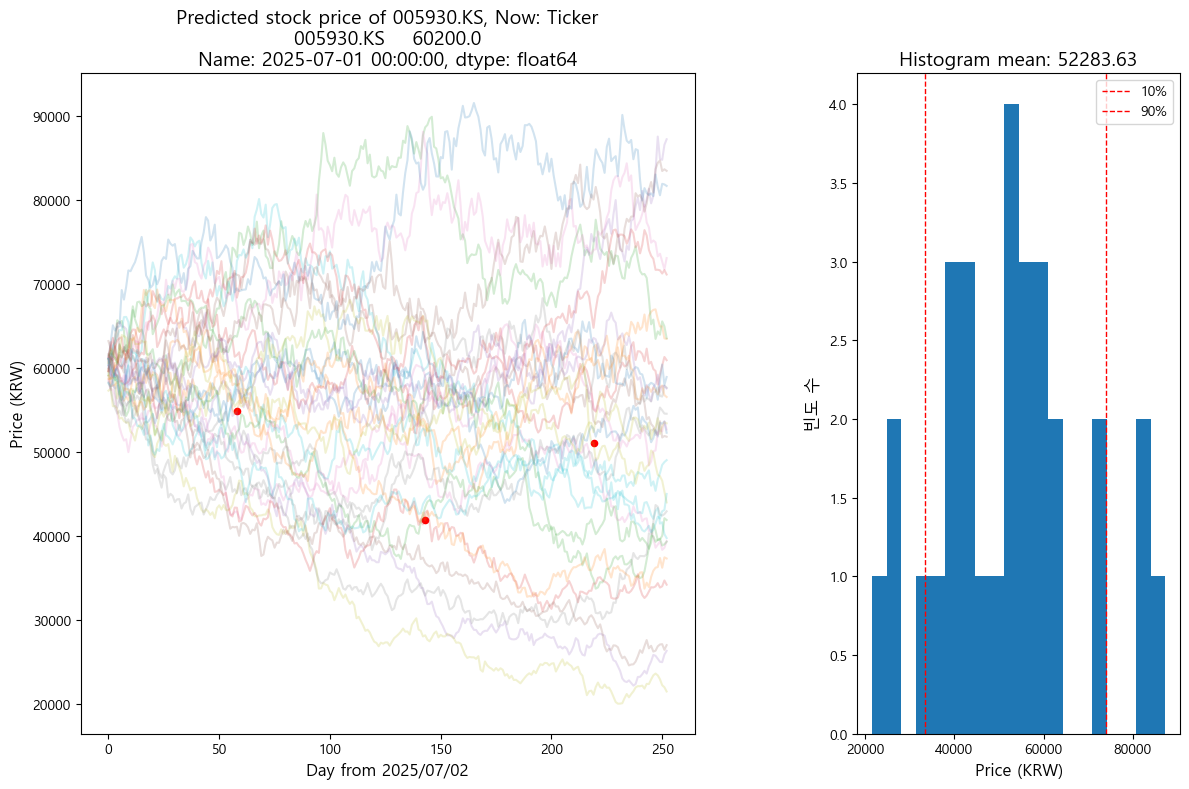

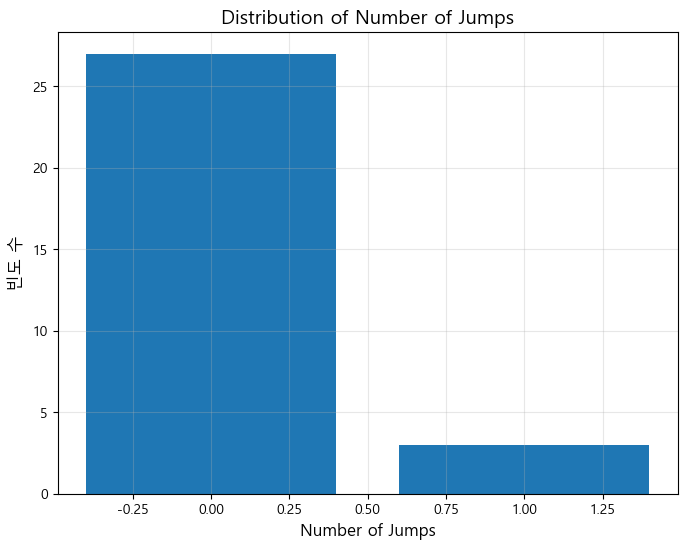

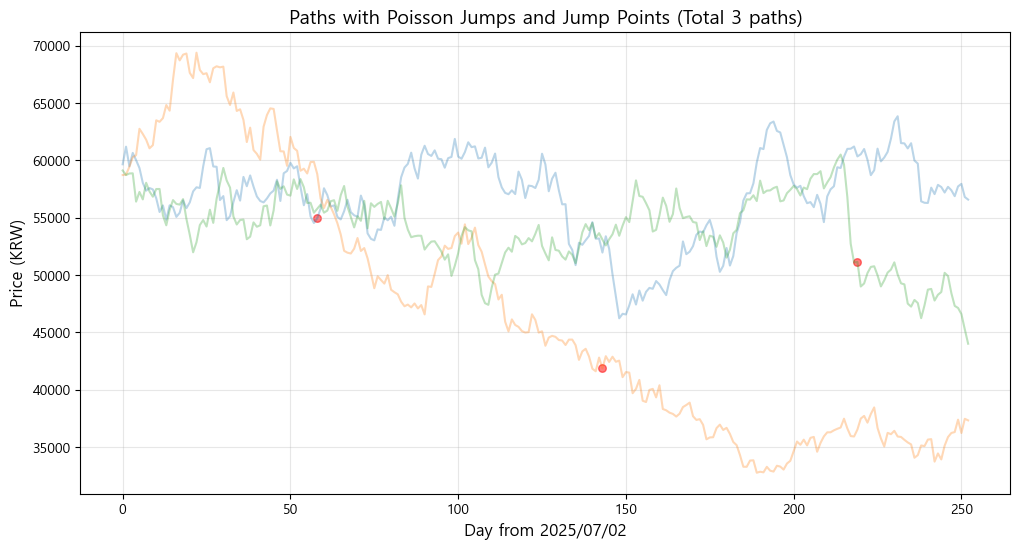

In [10]:

# ✅ 메인 함수 (종목코드 ticker를 인자로 받음)
def main(ticker):
    set_korean_font()
    stock_ticker = ticker
    stock_name = f'{ticker}'

    stock_data = load_stock_data(stock_ticker)
    mu, sigma = calc_return_stats(stock_data)
    last_price = stock_data['Close'].iloc[-1]

    # 시뮬레이션 실행
    price_df, last_price_list, jump_indices_list, count_jump = run_simulations(last_price, mu, sigma)

    today = date.today()
    plt.figure(figsize=(12, 8))
    figL = plt.subplot2grid((1, 12), (0, 0), colspan=7)
    figR = plt.subplot2grid((1, 12), (0, 8), colspan=4)

    # 1) 주가 시뮬레이션 경로 + 점프 표시
    for i in range(min(100, price_df.shape[1])):
        figL.plot(price_df.iloc[:, i], alpha=0.2)
        jumps = jump_indices_list[i]
        if jumps:
            figL.scatter(jumps, [price_df.iloc[j, i] for j in jumps], color='red', s=20, marker='o', label='Jump' if i == 0 else "")
    handles, labels = figL.get_legend_handles_labels()
    if 'Jump' in labels:
        figL.legend()
    figL.set_title(f'Predicted stock price of {stock_name}, Now: {round(last_price, 2)}', fontsize=14)
    figL.set_xlabel(f'Day from {today.strftime('%Y/%m/%d')}', fontsize=12)
    figL.set_ylabel('Price (KRW)', fontsize=12)

    # 2) 마지막 가격 히스토그램 (기존과 동일)
    tem = [int(price) for price in last_price_list]
    figR.hist(tem, bins=20)
    figR.axvline(np.percentile(tem, 10), color='r', linestyle='dashed', linewidth=1, label='10%')
    figR.axvline(np.percentile(tem, 90), color='r', linestyle='dashed', linewidth=1, label='90%')
    str_mean = str(round(np.mean(tem), 2))
    figR.set_title('Histogram mean: ' + str_mean, fontsize=14)
    figR.set_xlabel('Price (KRW)', fontsize=12)
    figR.set_ylabel('빈도 수', fontsize=12)
    figR.legend()
    plt.tight_layout()
    plt.show()
    
    # 점프 횟수 분포 시각화
    plt.figure(figsize=(8, 6))
    plt.hist(count_jump, bins=range(min(count_jump), max(count_jump) + 2, 1), 
            align='left', rwidth=0.8)
    plt.title('Distribution of Number of Jumps', fontsize=14)
    plt.xlabel('Number of Jumps', fontsize=12)
    plt.ylabel('빈도 수', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 점프가 발생한 경로와 점프 지점 시각화
    plt.figure(figsize=(12, 6))
    jump_paths = []
    jump_points = []
    
    # 점프가 있는 경로와 점프 지점 선별
    for i in range(len(count_jump)):
        if count_jump[i] > 0:
            jump_paths.append(price_df.iloc[:, i])
            jump_points.append((i, jump_indices_list[i]))
            
    # 점프 발생 경로와 점프 지점 그리기
    for idx, (path, (path_idx, jumps)) in enumerate(zip(jump_paths, jump_points)):
        plt.plot(path, alpha=0.3)
        plt.scatter(jumps, [price_df.iloc[j, path_idx] for j in jumps], 
                   color='red', s=30, alpha=0.5)
        
    plt.title(f'Paths with Poisson Jumps and Jump Points (Total {len(jump_paths)} paths)', fontsize=14)
    plt.xlabel(f'Day from {today.strftime("%Y/%m/%d")}', fontsize=12)
    plt.ylabel('Price (KRW)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()



# ✅ 실행
if __name__ == "__main__":
    main('005930.KS')  # ← 여기만 바꾸면 종목코드 변경 가능

### 손해액 시뮬레이션

* 보험금 수준 : 트리거 가격과 계약자가 주식을 판매한 시점의 가격 차이를 보험금으로 보상
* (하한 : Opening Price의 30%)
* 판매기한 : 뉴스 보도 이후 30일 이내로 판매 해야 함. 

In [23]:

# ✅ 몬테카를로 시뮬레이션
def run_loss_simulations(last_price, mu, daily_vol, num_simulations=100, T=252, lambda_event=0.13, jump_mu=-0.01, jump_vol=0.045, trigger_rate=0.05, epsilon = 0.006 ):
    df = pd.DataFrame()
    last_price_list = []
    jump_indices_list = []  # 점프 발생 인덱스 리스트 
    count_jump = []
    insurance_payments = []  # 보험금 지급 리스트
    insurance_premiums = []  # 보험료 납입 리스트
    lambda_event = lambda_event / 252
    
    KOFR = 0.0258     # KOFR 2.581%
    i = KOFR / 252

    for _ in range(num_simulations):
        count = 0
        price_list = []
        price = last_price * (1 + np.random.normal(mu, daily_vol))
        price_list.append(price)
        jump_indices = []  # 각 시뮬레이션별 점프 인덱스
        insurance_payment = 0  # 보험금 지급액
        insurance_premium = 0  # 보험료 납입액
        trigger_price = None  # 트리거 가격
        triggered = False

        for t in range(T):
            if not triggered:  # 보험금 수령 전까지만 보험료 납입
                temp = last_price * epsilon / 252# 일일 보험료 납입
                insurance_premium += temp * (1 + i) ** -t
                
            if triggered:
                price = trigger_price
            else:
                event = np.random.poisson(lambda_event)
                if event >= 1:
                    jump_return = np.random.normal(jump_mu, jump_vol) * 10 ########## 10일 동안 일방적으로 하락한다고 가정정
                    price_before_jump = price_list[count]
                    trigger_price = price_before_jump * (1 - trigger_rate)
                    price = price_before_jump * (1 - abs(jump_return))
                    
                    # 포아송 하락 점프로 인해 트리거 가격 이하로 떨어진 경우
                    if jump_return < 0 and price < trigger_price:
                        insurance_payment = trigger_price - price  # 손실액 보전
                        print(f'sim{count}에서 {t}일차에 보험금 지급발생!: {insurance_payment}')
                        price = trigger_price  # 보험금 지급 후 가격은 트리거 가격
                        triggered = True
                    jump_indices.append(count)
                else:
                    price = price_list[count] * (1 + np.random.normal(mu, daily_vol))
            
            price_list.append(price)
            count += 1

        df[len(df.columns)] = price_list
        last_price_list.append(price_list[-1])
        jump_indices_list.append(jump_indices)
        count_jump.append(len(jump_indices))
        insurance_payments.append(insurance_payment)
        insurance_premiums.append(insurance_premium)

    return df, last_price_list, jump_indices_list, count_jump, insurance_payments, insurance_premiums


In [33]:
# ✅ 메인 함수 (종목코드 ticker를 인자로 받음)
def viz_loss(ticker, params):
    set_korean_font()
    stock_ticker = ticker
    stock_name = f'{ticker}'

    stock_data = load_stock_data(stock_ticker)
    mu, sigma = calc_return_stats(stock_data)
    last_price = int(stock_data['Close'].iloc[-1])  # int로 변환


    # 시뮬레이션 실행
    price_df, last_price_list, jump_indices_list, count_jump, insurance_payments, insurance_premiums = run_loss_simulations(
        last_price, 
        mu, 
        sigma,
        num_simulations=params['num_simulations'], 
        T=params['T'], 
        lambda_event=params['lambda_event'], 
        jump_mu=params['jump_mu'], 
        jump_vol=params['jump_vol'],
        trigger_rate=params['trigger_rate'], 
        epsilon=params['epsilon'])

    today = date.today()
    
    plt.figure(figsize=(12, 6))
    fig = plt.gca()

    # 1) 주가 시뮬레이션 경로 + 점프 표시  
    for i in range(min(100, price_df.shape[1])):
        fig.plot(price_df.iloc[:, i], alpha=0.2)
        jumps = jump_indices_list[i]
        if jumps:
            fig.scatter(jumps, [price_df.iloc[j, i] for j in jumps], color='red', s=20, marker='o', label='Jump' if i == 0 else "")
    handles, labels = fig.get_legend_handles_labels()
    if 'Jump' in labels:
        fig.legend()
    fig.set_title(f'Predicted stock price of {stock_name}, Now: {round(last_price, 2)}', fontsize=14)
    fig.set_xlabel(f'Day from {today.strftime("%Y/%m/%d")}', fontsize=12)
    fig.set_ylabel('Price (KRW)', fontsize=12)

    plt.tight_layout()
    plt.show()
    
    # 2) 마지막 가격 히스토그램
    plt.figure(figsize=(12, 6))
    tem = [int(price) for price in last_price_list]
    plt.hist(tem, bins=20)
    plt.axvline(np.percentile(tem, 10), color='r', linestyle='dashed', linewidth=1, label='10%')
    plt.axvline(np.percentile(tem, 90), color='r', linestyle='dashed', linewidth=1, label='90%')
    str_mean = str(round(np.mean(tem), 2))
    plt.title('Histogram mean: ' + str_mean, fontsize=14)
    plt.xlabel('Price (KRW)', fontsize=12)
    plt.ylabel('빈도 수', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 점프 횟수 분포 시각화
    plt.figure(figsize=(8, 6))
    plt.hist(count_jump, bins=range(min(count_jump), max(count_jump) + 2, 1), 
            align='left', rwidth=0.8)
    plt.title('Distribution of Number of Jumps', fontsize=14)
    plt.xlabel('Number of Jumps', fontsize=12)
    plt.ylabel('빈도 수', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 점프가 발생한 경로와 점프 지점 시각화
    plt.figure(figsize=(12, 6))
    jump_paths = []
    jump_points = []
    
    # 점프가 있는 경로와 점프 지점 선별
    for i in range(len(count_jump)):
        if count_jump[i] > 0:
            jump_paths.append(price_df.iloc[:, i])
            jump_points.append((i, jump_indices_list[i]))
            
    # 점프 발생 경로와 점프 지점 그리기
    for idx, (path, (path_idx, jumps)) in enumerate(zip(jump_paths, jump_points)):
        plt.plot(path, alpha=0.3)
        plt.scatter(jumps, [price_df.iloc[j, path_idx] for j in jumps], 
                   color='red', s=30, alpha=0.5)
        
    plt.title(f'Paths with Poisson Jumps and Jump Points (Total {len(jump_paths)} paths)', fontsize=14)
    plt.xlabel(f'Day from {today.strftime("%Y/%m/%d")}', fontsize=12)
    plt.ylabel('Price (KRW)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 보험금 분포 시각화 및 통계량 계산
    plt.figure(figsize=(8, 6))
    # array 형태의 값을 int로 변환
    payments = [int(p[0]) if isinstance(p, np.ndarray) else p for p in insurance_payments]
    
    # 평균과 분산 계산
    mean_payment = np.mean(payments)
    var_payment = np.var(payments)
    
    # 서브플롯 생성
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # 왼쪽 그래프 - 전체 데이터
    ax1.boxplot(payments, widths=0.7)
    ax1.axhline(mean_payment, color='r', linestyle='dashed', linewidth=1, label=f'평균: {mean_payment:,.0f}원')
    ax1.set_title('전체 보험금 분포', fontsize=14)
    ax1.set_ylabel('Insurance Payment (KRW)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 오른쪽 그래프 - 최대값 제외
    filtered_payments = [p for p in payments if p != 0]
    ax2.hist(filtered_payments, bins=20)
    filtered_mean = np.mean(filtered_payments)
    ax2.axvline(filtered_mean, color='r', linestyle='dashed', linewidth=1, label=f'평균: {filtered_mean:,.0f}원')
    ax2.set_title('보험금 분포', fontsize=14)
    ax2.set_xlabel('Insurance Payment (KRW)', fontsize=12)
    ax2.set_ylabel('빈도 수', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 보험료 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # 왼쪽 그래프 - 전체 데이터
    ax1.boxplot(insurance_premiums, widths=0.7)
    mean_premium = np.mean(insurance_premiums)
    var_premium = np.var(insurance_premiums)
    ax1.axhline(mean_premium, color='r', linestyle='dashed', linewidth=1, label=f'평균: {mean_premium:,.0f}원')
    ax1.set_title('전체 보험료 분포', fontsize=14)
    ax1.set_ylabel('Insurance Premium (KRW)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 오른쪽 그래프 - 최댓값 제외
    filtered_premiums = [p for p in insurance_premiums if p != max(insurance_premiums)]
    filtered_mean = np.mean(filtered_premiums)
    filtered_var = np.var(filtered_premiums)
    ax2.hist(filtered_premiums, bins=20)
    ax2.axvline(filtered_mean, color='r', linestyle='dashed', linewidth=1, label=f'평균: {filtered_mean:,.0f}원')
    ax2.set_title('보험료 분포 (최댓값 제외)', fontsize=14)
    ax2.set_xlabel('Insurance Premium (KRW)', fontsize=12)
    ax2.set_ylabel('빈도 수', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 베이시스 리스크 측정을 위한 파이 차트
    plt.figure(figsize=(8, 6))
    
    # 보험금 수령자와 미수령자 계산
    received = sum(1 for p in payments if p > 0)
    not_received = len(payments) - received
    
    # 데이터와 레이블 준비
    sizes = [received, not_received]
    labels = [f'보험금 수령\n({received/len(payments)*100:.1f}%)', 
              f'보험금 미수령\n({not_received/len(payments)*100:.1f}%)']
    colors = ['lightcoral', 'lightblue']
    
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=90)
    plt.title('베이시스 리스크 측정\n(보험금 수령 여부 분포)', fontsize=14)
    plt.axis('equal')
    plt.show()
    
    # 평균 보험료와 평균 보험금 비교 시각화
    plt.figure(figsize=(12, 6))

    # 데이터 준비
    categories = ['평균 보험료', '평균 보험금']
    values = [mean_premium, mean_payment]

    # 막대 그래프 생성
    bars = plt.bar(categories, values, color=['lightblue', 'lightcoral'])

    # 막대 위에 값 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}원',
                ha='center', va='bottom')

    plt.title('평균 보험료와 평균 보험금 비교', fontsize=14)
    plt.ylabel('금액 (KRW)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # 손해율 계산 및 표시
    loss_ratio = (mean_payment / mean_premium) * 100
    plt.text(0.5, max(values) * 1.1, 
            f'손해율: {loss_ratio:.1f}%',
            ha='center', fontsize=12)

    plt.show()
    
    # 현재 손해율과 적정 손해율 비교
    plt.figure(figsize=(12, 6))

    # 데이터 준비
    loss_ratios = [loss_ratio, 70, 75, 80]
    labels = ['현재 손해율', '목표 손해율 70%', '목표 손해율 75%', '목표 손해율 80%']
    colors = ['lightcoral', 'lightblue', 'lightblue', 'lightblue']

    # 막대 그래프 생성
    bars = plt.bar(labels, loss_ratios, color=colors)

    # 막대 위에 값 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')

    plt.title('현재 손해율과 목표 손해율 비교', fontsize=14)
    plt.ylabel('손해율 (%)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # y축 범위 설정 (최소값의 90%부터 최대값의 110%까지)
    plt.ylim(min(loss_ratios) * 0.9, max(loss_ratios) * 1.1)

    plt.show()


In [ ]:
# 시뮬레이션 파라미터 설정
params = {
    'num_simulations': 100000,  # 시뮬레이션 횟수
    'T': 252,               # 시뮬레이션 기간(거래일)
    'lambda_event': 0.13,   # 점프 발생 확률
    'jump_mu': -0.01,       # 점프 크기의 평균
    'jump_vol': 0.045,      # 점프 크기의 표준편차
    'trigger_rate': 0.05,   # 트리거 수익률
    'epsilon': 0.006        # 보험요율
}


viz_loss('005930.KS', params)

[*********************100%***********************]  1 of 1 completed

sim20에서 20일차에 보험금 지급발생!: [1034.51474243]
sim169에서 169일차에 보험금 지급발생!: [176.9763252]
sim165에서 165일차에 보험금 지급발생!: [1649.620599]
sim225에서 225일차에 보험금 지급발생!: [174.01634392]
sim235에서 235일차에 보험금 지급발생!: [829.45606206]
sim83에서 83일차에 보험금 지급발생!: [1612.203772]
sim109에서 109일차에 보험금 지급발생!: [2834.26040111]
sim105에서 105일차에 보험금 지급발생!: [2239.96734095]
sim118에서 118일차에 보험금 지급발생!: [1883.09795987]
sim121에서 121일차에 보험금 지급발생!: [761.4963175]
sim62에서 62일차에 보험금 지급발생!: [21.26053306]
sim120에서 120일차에 보험금 지급발생!: [506.94444001]
sim12에서 12일차에 보험금 지급발생!: [1357.76763357]
sim78에서 78일차에 보험금 지급발생!: [132.70907444]
sim6에서 6일차에 보험금 지급발생!: [1227.3182823]
sim79에서 79일차에 보험금 지급발생!: [611.26108509]
sim71에서 71일차에 보험금 지급발생!: [2458.49366572]
sim105에서 105일차에 보험금 지급발생!: [2092.96748704]
sim165에서 165일차에 보험금 지급발생!: [1725.1449972]
sim29에서 29일차에 보험금 지급발생!: [757.25963452]
sim136에서 136일차에 보험금 지급발생!: [615.01302789]
sim192에서 192일차에 보험금 지급발생!: [414.08649699]
sim223에서 223일차에 보험금 지급발생!: [651.08533311]
sim56에서 56일차에 보험금 지급발생!: [1821.81303687]
sim68에서 68일

* 할인율
https://www.kofr.kr/main.jsp



### 적정 보험요율 산정 방법론

* 적정 보험요율 = 현재 보험요율 × (목표 손해율 / 현재 손해율)

목표 손해율 70%: 적정요율 9.16%

목표 손해율 75%: 적정요율 9.82%

목표 손해율 80%: 적정요율 10.47%

![](./insurance_current.png)

![](./basis_risk.png)